This notebook contains the code used in the BigComp 2022 paper: <br>
<b>Heeryon Cho, Woo-Kyu Kang, Younsoo Park, Sungeu Chae, and Seong-joon Kim, "Multi-label Facial Emotion Recognition Using Korean Drama Movie Clips," BigComp 2022.</b>
### ResNet50 /  Classify 6 Basic Emotions

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as rn
import os

In [2]:
import warnings
import logging
logging.getLogger('tensorflow').disabled = True
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
# Record cell run time.
!pip install ipython-autotime

%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 27.7 MB/s 
time: 573 µs (started: 2022-10-26 03:35:57 +00:00)


In [4]:
# Set seed for reproducibility.

set_seed = 46
np.random.seed(set_seed)
rn.seed(set_seed)
tf.random.set_seed(set_seed)

time: 4.67 ms (started: 2022-10-26 03:35:57 +00:00)


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
time: 15.2 s (started: 2022-10-26 03:36:08 +00:00)


In [6]:
!pip install --extra-index-url https://developer.download.nvidia.com/compute/redist --upgrade nvidia-dali-cuda110
!pip install --extra-index-url https://developer.download.nvidia.com/compute/redist --upgrade nvidia-dali-tf-plugin-cuda110

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://developer.download.nvidia.com/compute/redist
     |████████████████████████████████| 376.1 MB 10 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://developer.download.nvidia.com/compute/redist
     |████████████████████████████████| 438 kB 6.6 MB/s 
  Created wheel for nvidia-dali-tf-plugin-cuda110: filename=nvidia_dali_tf_plugin_cuda110-1.18.0-cp37-cp37m-linux_x86_64.whl size=126872 sha256=6875ae007875b85f2c1f8c0d09cc0471af0b3850c604bfd4094f89f107513729
  Stored in directory: /root/.cache/pip/wheels/09/72/ac/d233654aa46be315a8b91ba5c268476d42de920c6a58116219
Successfully built nvidia-dali-tf-plugin-cuda110
time: 44.6 s (started: 2022-10-26 03:36:24 +00:00)


### Load label data.

In [7]:
# Load labels, check headers, check data shape.

f_PATH = "/content/drive/MyDrive/facial_emotion_recognition_using_K-drama_dataset-main/"

df_label = pd.read_csv(f_PATH+'label/label_6_basic_emo.csv')
print(df_label.columns)
print(df_label.shape)

LABELS = list(df_label.columns[2:])
print("LABELS=", LABELS)
print("All class:", len(LABELS))

label_valid = pd.read_csv(f_PATH+'label/label_6_basic_emo_valid.csv')
label_train = pd.read_csv(f_PATH+'label/label_6_basic_emo_train.csv')
label_test = pd.read_csv(f_PATH+'label/label_6_basic_emo_test.csv')

VALID_DATA_SIZE = label_valid.shape[0]
TRAIN_DATA_SIZE = label_train.shape[0]
TEST_DATA_SIZE = label_test.shape[0]

print("TRAIN_DATA_SIZE:", label_train.shape[0])
print("VALID_DATA_SIZE:", label_valid.shape[0])
print("TEST_DATA_SIZE:", label_test.shape[0])

Index(['img_id', 'clip_id', 'angry', 'disgusted', 'surprised', 'fearful',
       'happy', 'sad'],
      dtype='object')
(12813, 8)
LABELS= ['angry', 'disgusted', 'surprised', 'fearful', 'happy', 'sad']
All class: 6
TRAIN_DATA_SIZE: 10249
VALID_DATA_SIZE: 1282
TEST_DATA_SIZE: 1282
time: 1.22 s (started: 2022-10-26 03:37:10 +00:00)


### Calculate class weights.

In [8]:
dict_label_train = {}
for idx, row in label_train.iterrows():
    dict_label_train[row['img_id']] = list(row['angry':'sad'].values)
len(dict_label_train)

10249

time: 2.46 s (started: 2022-10-26 03:37:11 +00:00)


In [9]:
y_train_ls = list(dict_label_train.values())
#y_train_ls

time: 1.13 ms (started: 2022-10-26 03:37:14 +00:00)


In [10]:
y_train_ints = [y.index(1) for y in y_train_ls]
#y_train_ints

time: 3.5 ms (started: 2022-10-26 03:37:14 +00:00)


In [11]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(y_train_ints),
                                                  y=y_train_ints)
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: 0.2815040650406504,
 1: 18.3673835125448,
 2: 0.7868109933978198,
 3: 7.6257440476190474,
 4: 11.46420581655481,
 5: 1.106325561312608}

time: 176 ms (started: 2022-10-26 03:37:26 +00:00)


In [12]:
class_weights

array([ 0.28150407, 18.36738351,  0.78681099,  7.62574405, 11.46420582,
        1.10632556])

time: 11.9 ms (started: 2022-10-26 03:37:29 +00:00)


In [13]:
n_samples = len(dict_label_train)
n_classes = len(set(y_train_ints))

time: 1.01 ms (started: 2022-10-26 03:37:29 +00:00)


In [14]:
multiplier = 3
adjusted_cw = class_weights / n_classes * multiplier
adjusted_cw

array([0.14075203, 9.18369176, 0.3934055 , 3.81287202, 5.73210291,
       0.55316278])

time: 12.7 ms (started: 2022-10-26 03:37:29 +00:00)


In [15]:
log_weights = n_samples / (n_classes * np.log(np.bincount(y_train_ints)))
sum_weights = sum(log_weights)
sum_weights
custom_class_weights = log_weights / sum_weights
custom_class_weights

array([0.11638164, 0.22366313, 0.13195144, 0.18733217, 0.20259518,
       0.13807644])

time: 21.2 ms (started: 2022-10-26 03:37:30 +00:00)


In [16]:
custom_class_weights += adjusted_cw
custom_class_weights

array([0.25713368, 9.40735489, 0.52535693, 4.00020419, 5.93469809,
       0.69123922])

time: 15.8 ms (started: 2022-10-26 03:37:31 +00:00)


In [17]:
class_weight_dict = dict(enumerate(custom_class_weights))
class_weight_dict

{0: 0.25713367600252574,
 1: 9.407354888012607,
 2: 0.5253569344678802,
 3: 4.0002041936980595,
 4: 5.934698087278068,
 5: 0.6912392187757267}

time: 18.7 ms (started: 2022-10-26 03:37:32 +00:00)


### Define training pipeline.

In [18]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.fn as fn
import nvidia.dali.types as types
import nvidia.dali.tfrecord as tfrec
import nvidia.dali.plugin.tf as dali_tf

class TFRecordPipelineTrain(Pipeline):
    def __init__(self, batch_size, num_threads,
                 device = 'cpu', device_id = 0):
        super(TFRecordPipelineTrain, self).__init__(batch_size,
                                         num_threads,
                                         device_id)
        self.input = fn.readers.tfrecord(        
             features = {"image_raw": tfrec.FixedLenFeature((), tfrec.string, ""),
                         "label": tfrec.FixedLenFeature([6], tfrec.int64,  6)},
             path = [f_PATH+'tfrecords/6_basic_emo_train.tfrecords'],
             index_path = [f_PATH+'tfrecords/6_basic_emo_train.idx'],
             random_shuffle=True,
             seed = set_seed)
        self.iter = 0
    def define_graph(self):
        inputs = self.input
        images = fn.decoders.image(inputs["image_raw"], device = "mixed", output_type = types.RGB) / 255.
        labels = inputs["label"].gpu()
        return (images, labels)
    def iter_setup(self):
        pass

time: 111 ms (started: 2022-10-26 03:37:45 +00:00)


### Define validation pipeline.

In [19]:
class TFRecordPipelineValid(Pipeline):
    def __init__(self, batch_size, num_threads,
                 device = 'cpu', device_id = 0):
        super(TFRecordPipelineValid, self).__init__(batch_size,
                                         num_threads,
                                         device_id)
        self.input = fn.readers.tfrecord(        
             features = {"image_raw": tfrec.FixedLenFeature((), tfrec.string, ""),
                         "label": tfrec.FixedLenFeature([6], tfrec.int64,  6)},
             path = [f_PATH+'tfrecords/6_basic_emo_valid.tfrecords'],
             index_path = [f_PATH+'tfrecords/6_basic_emo_valid.idx'],
             random_shuffle=False,
             seed = set_seed)
        self.iter = 0
    def define_graph(self):
        inputs = self.input
        images = fn.decoders.image(inputs["image_raw"], device = "mixed", output_type = types.RGB) / 255.
        labels = inputs["label"].gpu()
        return (images, labels)
    def iter_setup(self):
        pass

time: 9.82 ms (started: 2022-10-26 03:37:54 +00:00)


### Train ResNet50 model for classifying 6 basic emotions.

In [20]:
# https://www.tensorflow.org/tutorials/images/transfer_learning
# https://keras.io/guides/transfer_learning/

if __name__ == "__main__":
    batch_size = 64
    shapes = ((batch_size, 64, 64, 3),
              (batch_size, 6))
    pipe_train = TFRecordPipelineTrain(batch_size=batch_size, 
                                 num_threads=1, 
                                 device='gpu', 
                                 device_id=0)
    
    batch_size_valid = 64
    shapes_valid = ((batch_size_valid, 64, 64, 3),
              (batch_size_valid, 6))
    pipe_valid = TFRecordPipelineValid(batch_size=batch_size_valid, 
                                 num_threads=1, 
                                 device='gpu', 
                                 device_id=0)   

    with tf.device('/gpu:0'):
        ds_train = dali_tf.DALIDataset(
            pipeline=pipe_train,
            batch_size=batch_size,
            output_shapes=shapes,
            output_dtypes=(tf.float32, tf.int64),
            device_id=0)

        ds_valid = dali_tf.DALIDataset(
            pipeline=pipe_valid,
            batch_size=batch_size_valid,
            output_shapes=shapes_valid,
            output_dtypes=(tf.float32, tf.int64),
            device_id=0)  
      
        initializer = keras.initializers.GlorotUniform(seed=set_seed)
        activation =  keras.activations.softmax
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=1e-5,
            decay_steps=TRAIN_DATA_SIZE // batch_size * 10,
            decay_rate=0.95)       

        number_of_classes = 6        
        
        base_model = keras.applications.ResNet50(
            weights='imagenet',  # Load weights pre-trained on ImageNet.
            input_shape=(64, 64, 3), # VGG16 expects min 32 x 32
            include_top=False, # Do not include the ImageNet classifier at the top.
            pooling='avg') # average pooling added 
        
        base_model.trainable = True   # Unfreeze ResNet50 weights.        
        
        # See how many layers are in the base model.
        print("Number of layers in the base model: ", len(base_model.layers))
        
        # Fine-tune from this layer onwards.
        fine_tune_at = 120
        
        # Freeze all the layers before the `fine_tune_at` layer.
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable =  False    
       
        inputs = keras.Input(shape=(64, 64, 3))
        x = base_model(inputs)
        fc1 = keras.layers.Dense(number_of_classes,
                             kernel_initializer=initializer)(x)
        do1 = keras.layers.Dropout(0.5, seed=set_seed)(fc1)
        outputs = keras.layers.Dense(number_of_classes,
                             kernel_initializer=initializer,
                             activation=activation)(do1) 
        clf = keras.Model(inputs, outputs)
        
        clf.summary()
              
        # Apply early stopping.        
        es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,
                                                       restore_best_weights=True)
       
        clf.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
        
        history = clf.fit(ds_train, steps_per_epoch=TRAIN_DATA_SIZE // batch_size,
                          validation_data=ds_valid.take(VALID_DATA_SIZE // batch_size_valid),
                          epochs=1000,
                          class_weight=class_weight_dict,
                          callbacks=[es_callback])

94765736/94765736 [==============================] - 1s 0us/step
Number of layers in the base model:  176
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 6)                 12294     
                                                                 
 dropout (Dropout)           (None, 6)                 0         
                                                                 
 dense_1 (Dense)             (None, 6)                 42        
                                                                 
Total params: 23,600,048
Trainable params: 17,227,824
Non-trainable params: 6,372,224
_

In [21]:
# List all data in history.

print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
time: 846 µs (started: 2022-10-26 03:45:12 +00:00)


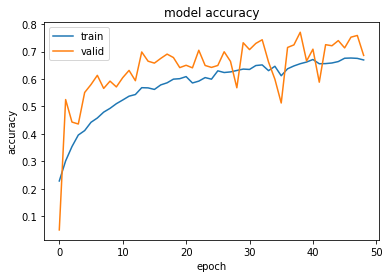

time: 154 ms (started: 2022-10-26 03:45:12 +00:00)


In [22]:
# Summarize history for accuracy.

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

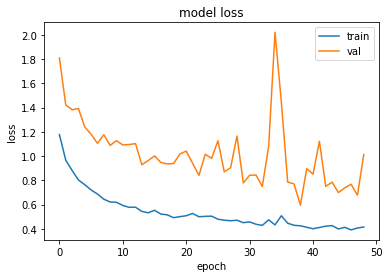

time: 132 ms (started: 2022-10-26 03:45:12 +00:00)


In [23]:
# Summarize history for loss.

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

### Define test pipeline.

In [24]:
class TFRecordPipelineTest(Pipeline):
    def __init__(self, batch_size, num_threads,
                 device = 'cpu', device_id = 0):
        super(TFRecordPipelineTest, self).__init__(batch_size,
                                         num_threads,
                                         device_id)
        self.input = fn.readers.tfrecord(        
             features = {"image_raw": tfrec.FixedLenFeature((), tfrec.string, ""),
                         "label": tfrec.FixedLenFeature([6], tfrec.int64,  6)},
             path = [f_PATH+'tfrecords/6_basic_emo_test.tfrecords'],
             index_path = [f_PATH+'tfrecords/6_basic_emo_test.idx'],
             random_shuffle=False,
             seed = set_seed)
        self.iter = 0
    def define_graph(self):
        inputs = self.input
        images = fn.decoders.image(inputs["image_raw"], device = "mixed", output_type = types.RGB) / 255.
        labels = inputs["label"].gpu()
        return (images, labels)
    def iter_setup(self):
        pass

time: 4.38 ms (started: 2022-10-26 03:45:14 +00:00)


### Check test data accuracy.

In [25]:
# https://docs.nvidia.com/deeplearning/dali/user-guide/docs/plugins/tensorflow_plugin_api.html

if __name__ == "__main__":
    batch_size = 1
    shapes = ((batch_size, 64, 64, 3),
              (batch_size, 6))
    pipe_test = TFRecordPipelineTest(batch_size=batch_size, 
                            num_threads=4, 
                            device='gpu', 
                            device_id=0)

    with tf.device('/gpu:0'):
        ds_test = dali_tf.DALIDataset(
            pipeline=pipe_test,
            batch_size=batch_size,
            output_shapes=shapes,
            output_dtypes=(tf.float32, tf.int64),
            device_id=0)
        loss, acc = clf.evaluate(ds_test, steps=TEST_DATA_SIZE)
        print("Test accuracy:", acc)
        predictions = clf.predict(ds_test.take(5))
        print("A test output from the last layer:", predictions[0])
        print("Index of the maximum value:", np.argmax(predictions[0]))
        print("Label:", LABELS[np.argmax(predictions[0])])

1282/1282 [==============================] - 15s 10ms/step - loss: 0.6198 - accuracy: 0.7715
Test accuracy: 0.7714508771896362
5/5 [==============================] - 1s 8ms/step
A test output from the last layer: [0.85035616 0.00700823 0.00322225 0.03618122 0.01936608 0.08386601]
Index of the maximum value: 0
Label: angry
time: 15.8 s (started: 2022-10-26 03:45:14 +00:00)


In [26]:
predictions

array([[8.5035616e-01, 7.0082266e-03, 3.2222457e-03, 3.6181223e-02,
        1.9366080e-02, 8.3866008e-02],
       [3.1288913e-01, 3.4263663e-02, 4.1830361e-02, 5.4533515e-02,
        3.1154531e-01, 2.4493805e-01],
       [2.1603731e-02, 1.2441709e-01, 7.9087776e-01, 2.1272670e-02,
        1.3008864e-02, 2.8819907e-02],
       [9.1081440e-01, 9.8760948e-03, 1.1813388e-03, 1.1222595e-02,
        9.8323124e-03, 5.7073280e-02],
       [9.8738343e-01, 9.6845914e-05, 3.2364507e-05, 1.3594998e-03,
        6.1611785e-04, 1.0511763e-02]], dtype=float32)

time: 6.39 ms (started: 2022-10-26 03:45:29 +00:00)


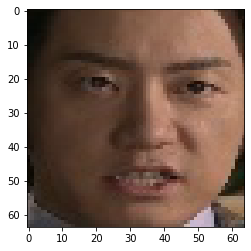

time: 158 ms (started: 2022-10-26 03:45:29 +00:00)


In [27]:
# Display the tested image.

import matplotlib.pyplot as plt

data, = ds_test.take(1)
plt.imshow(data[0][0])

In [28]:
# Check the test data's true label.
data[1]

<tf.Tensor: shape=(1, 6), dtype=int64, numpy=array([[1, 0, 0, 0, 0, 0]])>

time: 7.13 ms (started: 2022-10-26 03:45:30 +00:00)


In [29]:
data

(<tf.Tensor: shape=(1, 64, 64, 3), dtype=float32, numpy=
 array([[[[0.03921569, 0.03529412, 0.01176471],
          [0.05098039, 0.04705882, 0.02352941],
          [0.04705882, 0.05098039, 0.02352941],
          ...,
          [0.14509805, 0.08627451, 0.05882353],
          [0.08235294, 0.0627451 , 0.03137255],
          [0.09411765, 0.07450981, 0.04313726]],
 
         [[0.03921569, 0.03529412, 0.01176471],
          [0.04313726, 0.03921569, 0.01568628],
          [0.03529412, 0.03921569, 0.01176471],
          ...,
          [0.17254902, 0.11372549, 0.08627451],
          [0.08627451, 0.06666667, 0.03529412],
          [0.09411765, 0.07450981, 0.04313726]],
 
         [[0.04313726, 0.04313726, 0.02745098],
          [0.04313726, 0.04313726, 0.02745098],
          [0.03137255, 0.04313726, 0.02352941],
          ...,
          [0.21568628, 0.12941177, 0.09411765],
          [0.11372549, 0.06666667, 0.03529412],
          [0.15294118, 0.10588235, 0.07450981]],
 
         ...,
 
         

time: 7.67 ms (started: 2022-10-26 03:45:30 +00:00)


In [30]:
pred_test = clf.predict(ds_test.take(TEST_DATA_SIZE))

1282/1282 [==============================] - 10s 8ms/step
time: 10.7 s (started: 2022-10-26 03:45:30 +00:00)


In [31]:
true_test = np.concatenate([y for x, y in ds_test.take(TEST_DATA_SIZE)], axis=0)

time: 738 ms (started: 2022-10-26 03:45:40 +00:00)


In [32]:
true_test.shape

(1282, 6)

time: 11.6 ms (started: 2022-10-26 03:45:41 +00:00)


In [33]:
from sklearn.metrics import confusion_matrix

pred_test_ls = []
true_test_ls = []
for (pred, true) in zip(pred_test, true_test):
    pred_test_ls.append(np.argmax(pred))
    true_test_ls.append(np.argmax(true))

cf_matrix_test = confusion_matrix(true_test_ls, pred_test_ls)
cf_matrix_test

array([[705,   7,  29,   2,  16,   0],
       [  0,  11,   0,   0,   1,   0],
       [ 36,   3, 229,   1,   3,   0],
       [  0,   0,   2,  26,   0,   0],
       [  0,   0,   0,   0,  18,   0],
       [115,   0,  12,   0,  66,   0]])

time: 62.6 ms (started: 2022-10-26 03:45:41 +00:00)


Text(33.0, 0.5, 'True')

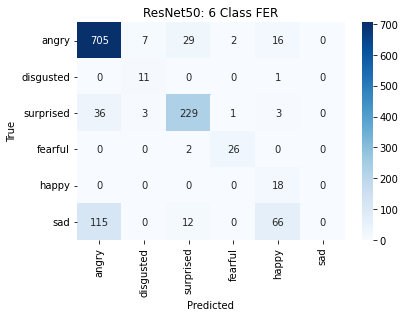

time: 389 ms (started: 2022-10-26 03:45:41 +00:00)


In [34]:
import seaborn as sns

sns.heatmap(cf_matrix_test, annot=True, cmap='Blues', xticklabels=LABELS, yticklabels=LABELS, fmt='g')
plt.title('ResNet50: 6 Class FER')
plt.xlabel('Predicted')
plt.ylabel('True')

### Check train data accuracy.

In [35]:
# https://docs.nvidia.com/deeplearning/dali/user-guide/docs/plugins/tensorflow_plugin_api.html

if __name__ == "__main__":
    batch_size = 1
    shapes = ((batch_size, 64, 64, 3),
              (batch_size, 6))
    pipe_train = TFRecordPipelineTrain(batch_size=batch_size, 
                            num_threads=4, 
                            device='gpu', 
                            device_id=0)

    with tf.device('/gpu:0'):
    #with strategy.scope():        
        # Create dataset
        ds_train = dali_tf.DALIDataset(
            pipeline=pipe_train,
            batch_size=batch_size,
            output_shapes=shapes,
            output_dtypes=(tf.float32, tf.int64),
            device_id=0)
        loss, acc = clf.evaluate(ds_train, steps=TRAIN_DATA_SIZE)
        print("Train accuracy:", acc)
        #predictions = clf.predict(ds_train.take(1))
        #print("A test output from the last layer:", predictions[0])
        #print("Index of the maximum value:", np.argmax(predictions[0]))
        #print("Label:", LABELS[np.argmax(predictions[0])])

10249/10249 [==============================] - 105s 10ms/step - loss: 0.4853 - accuracy: 0.8057
Train accuracy: 0.8057371377944946
time: 1min 44s (started: 2022-10-26 03:45:42 +00:00)


In [36]:
pred_train = clf.predict(ds_train.take(TRAIN_DATA_SIZE))

10249/10249 [==============================] - 82s 8ms/step
time: 1min 24s (started: 2022-10-26 03:47:26 +00:00)


In [37]:
true_train = np.concatenate([y for x, y in ds_train.take(TRAIN_DATA_SIZE)], axis=0)

time: 5.47 s (started: 2022-10-26 03:48:51 +00:00)


In [38]:
true_train.shape

(10249, 6)

time: 5.01 ms (started: 2022-10-26 03:48:56 +00:00)


In [39]:
pred_train_ls = []
true_train_ls = []
for (pred, true) in zip(pred_train, true_train):
    pred_train_ls.append(np.argmax(pred))
    true_train_ls.append(np.argmax(true))

cf_matrix_train = confusion_matrix(true_train_ls, pred_train_ls)
cf_matrix_train

array([[5781,   33,  115,    7,  132,    0],
       [   0,   93,    0,    0,    0,    0],
       [ 119,   20, 2004,    2,   26,    0],
       [   1,    0,    0,  223,    0,    0],
       [   0,    0,    0,    0,  149,    0],
       [ 871,    2,  108,    0,  555,    8]])

time: 53.7 ms (started: 2022-10-26 03:48:56 +00:00)


Text(33.0, 0.5, 'True')

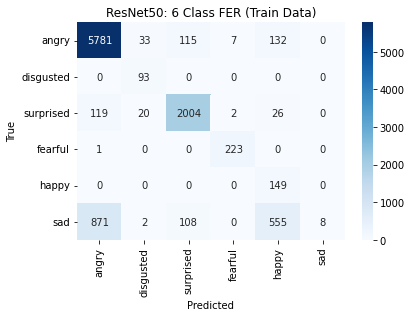

time: 317 ms (started: 2022-10-26 03:48:56 +00:00)


In [40]:
sns.heatmap(cf_matrix_train, annot=True, cmap='Blues', xticklabels=LABELS, yticklabels=LABELS, fmt='g')
plt.title('ResNet50: 6 Class FER (Train Data)')
plt.xlabel('Predicted')
plt.ylabel('True')